## Python

Задачи:

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from tqdm.auto import tqdm
import requests
from scipy import stats
from urllib.parse import urlencode
from tqdm.auto import tqdm

%matplotlib inline 

1.2 Входные данные

В качестве входных данных  имеется 4 csv-файла:

Считаем файлы и запишем их в переменные.

In [2]:
def yandex_data(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [3]:
groups       =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
checks       =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 
active_studs =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';')
group_add    =  pd.read_csv(yandex_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',')

Анализ считываемых файлов проведен в проекте "А/B test". Для создания функции повторим шаги из проекта "А/B test" по объединению датафреймов.

В датафреймах "checks" и "active_studs" переименуем столбец "student_id" в "id"

In [4]:
checks.rename(columns={'student_id': 'id'}, inplace=True)
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

Проверяем:

количество повторяющихся значений в "checks" в колонке "id", по которой будет производиться объединение;

количество повторяющихся значений в "active_studs" в колонке "id", по которой будет производиться объединение;

количество пропущенных значений.

In [5]:
duplicate_checks = checks[checks.duplicated(['id'])]
duplicate_checks.shape

(0, 2)

In [6]:
duplicate_active_studs = active_studs[active_studs.duplicated(['id'])]
duplicate_active_studs.shape

(0, 1)

In [7]:
checks.isna().sum()

id     0
rev    0
dtype: int64

In [8]:
active_studs.isna().sum()

id    0
dtype: int64

Добавляем дополнительные колонки:

In [9]:
group_add['added_later'] = True
active_studs['active_studs'] = True

Объединим датафреймы. Поскольку датафрейм "groups_add" был передан спустя два дня после получения основных данных, а о происхождении добавленных пользователей ничего неизвестно, и о периоде проведения эксперимента тоже то будем считать, что эти данные собирались из разных источников, но в рамках проведения эксперимента. Поэтому включаем пользователей из датафрейма "groups_add" в АБ-тест.

In [10]:
df_all = groups.merge(group_add, how='outer', on=['id', 'grp'])
df_all = df_all.merge(active_studs, how='outer', on=['id'])
df_all = df_all.merge(checks, how='outer', on=['id'])

Заполняем NaN значения значениями по умолчанию:

In [11]:
df_all['added_later'] = df_all.added_later.fillna(False)
df_all['active_studs'] = df_all.active_studs.fillna(False)
df_all['grp'] = df_all.grp.astype('string')

Посмотрим на полученный датафрейм:

In [12]:
df_all.head()

,id,grp,added_later,active_studs,rev
0,1489,B,False,False,NaN
1,1627,A,False,True,990.0
2,1768,B,False,False,NaN
3,1783,B,False,False,NaN
4,1794,A,False,False,NaN


Реализуем функцию,которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [13]:
def metrics (add = None, #ДатаФрейм
                keys=['id', 'grp'], # Ключи, по которым нужно объединить ДатаФрейм с основной таблицей
                rename_columns = {'student_id':'id'} # Переименовывем столбцы для корректного объединения
               ):
    import pandas as pd
    def yandex_data(public_key): # Функция, которая считывает csv-файлы с Яндекс-диска с помощью API
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url) 
        download_url = response.json()['href'] 
        return download_url
    groups       = pd.read_csv(yandex_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';', dtype={'id' : 'int64', 'grp' : 'string'})
    active_studs = pd.read_csv(yandex_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';', dtype={'student_id' : 'int64'})
    checks       = pd.read_csv(yandex_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';', dtype={'student_id' : 'int64', 'rev' : 'float64'})

    # Переименовываем колонки для объединенения по ключам
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True) 

    # Добавляем дополнительную колонку
    active_studs['active_studs'] = True

    # Объединяем таблицы в одну общую
    df_final = groups.merge(active_studs, how='outer', on=['id'])
    df_final = df_final.merge(checks, how='outer', on=['id'])
    
    # Добавляем условие, если в параметр add была передана таблица
    if add is not None:
        add = add.rename(columns=rename_columns)
        df_final ['added_later'] = True # Добавляем дополнительную колонку
        df_final = df_all.merge(add, how='outer') # Писоединяем таблицу к общей
        df_final['added_later'] = df_final.added_later.fillna(False) # Заполняем NaN значения значениями по умолчанию
    
    # Заполняем NaN значения значениями по умолчанию
    df_final['active_studs'] = df_all.active_studs.fillna(False)

    # Присваиваем столбцу grp тип string
    df_all ['grp'] = df_all.grp.astype('string')
    
    # отфильтровываем только активных пользователей и оплативших
    # !!!раскомментировать при необходимости
    # df_final = df_final.query('active_studs == True or rev.notna()')
    
    # Расчитываем метрики
    result_df = pd.DataFrame()
    result_df['CR_to_clients'] = df_final.groupby('grp').rev.count() / df_final.groupby('grp').id.count()
    result_df['mean_revenue'] = df_final.groupby('grp').rev.mean()
    result_df['repeat_purchases'] = df_final.groupby('grp').rev.count() / df_final.query('rev.notna()').groupby('grp').rev.count()
    result_df['arppu'] = result_df['repeat_purchases'] * df_final.groupby('grp').rev.mean()
    result_df['arpu'] = result_df['CR_to_clients']*result_df['arppu']
    result_df = result_df.reset_index().rename(columns={'index' : 'grp'})
    
    return {"metrics" : result_df, 
            "data_frame" : df_final}

Проверим функцию без group_add:

In [14]:
a = metrics()

In [15]:
a['metrics']

,grp,CR_to_clients,mean_revenue,repeat_purchases,arppu,arpu
0,A,0.007293,860.710280,1.0,860.710280,6.277418
1,B,0.007239,1106.997699,1.0,1106.997699,8.013810


In [16]:
a['data_frame']

,id,grp,active_studs,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN
...,...,...,...,...
74492,5740903,<NA>,False,1900.0
74493,5760471,<NA>,False,NaN
74494,5728431,<NA>,False,NaN
74495,5723648,<NA>,False,NaN


Проверим функцию с group_add:

In [17]:
b = metrics(group_add, keys=['id', 'grp'])

In [18]:
b['metrics']

,grp,CR_to_clients,mean_revenue,repeat_purchases,arppu,arpu
0,A,0.007282,860.710280,1.0,860.710280,6.268019
1,B,0.007247,1108.824893,1.0,1108.824893,8.036171


In [19]:
b['data_frame']

,id,grp,added_later,active_studs,rev
0,1489,B,False,False,NaN
1,1627,A,False,True,990.0
2,1768,B,False,False,NaN
3,1783,B,False,False,NaN
4,1794,A,False,False,NaN
...,...,...,...,...,...
74571,200247820,B,True,False,NaN
74572,201032527,B,True,False,NaN
74573,201067612,B,True,False,NaN
74574,201067653,B,True,False,NaN


Реализуем функцию, которая будет строить графики по получаемым метрикам.

In [20]:
def visualization(df):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.tight_layout(h_pad=5)
    sns.barplot(y='CR_to_clients', x="grp", data=df, ax=axs[0, 0]).set_title('CR_to_clients')
    sns.barplot(y='mean_revenue', x="grp", data=df, ax=axs[0, 1]).set_title('Mean_Revenue')
    sns.barplot(y='arppu', x="grp", data=df, ax=axs[1, 0]).set_title('ARPPU')
    sns.barplot(y='arpu', x="grp", data=df, ax=axs[1, 1]).set_title('ARPU')
    
    plt.show()

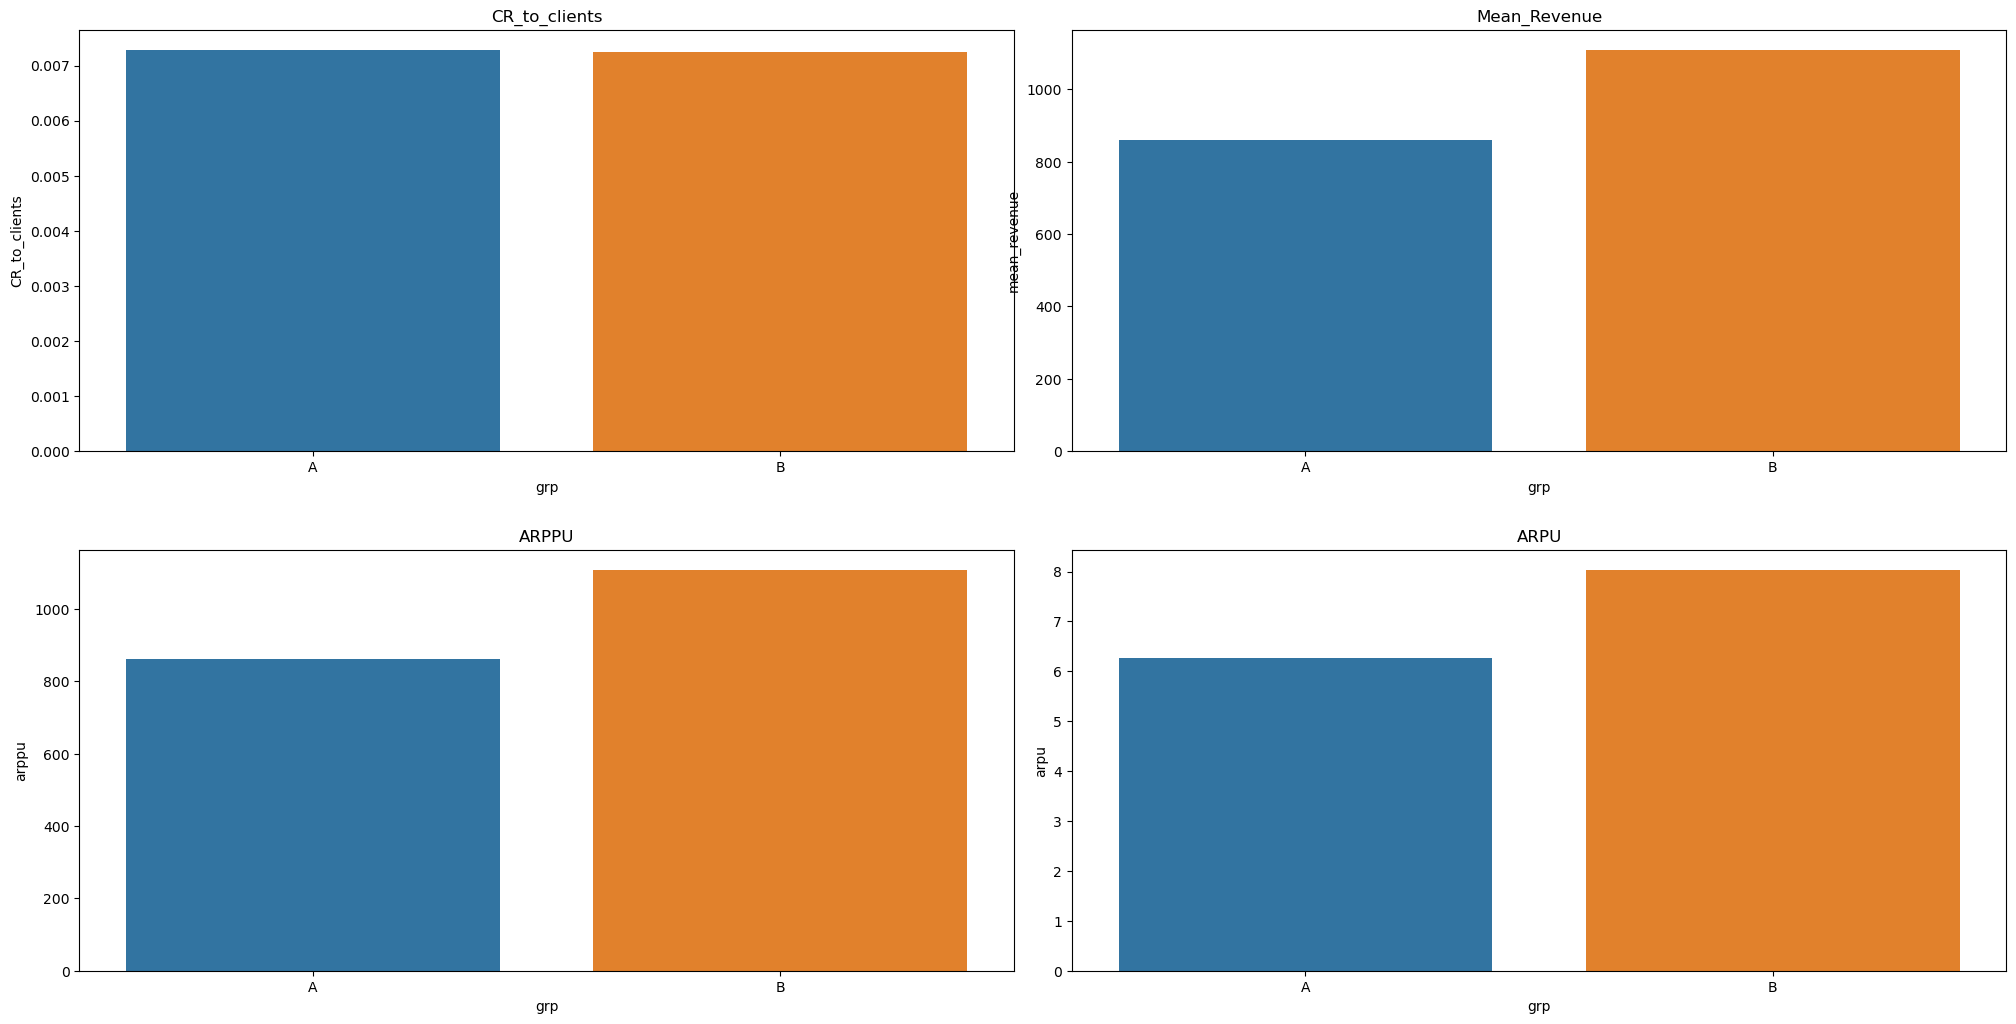

In [21]:
visualization(b['metrics'])